In [1]:
import sys
sys.path.insert(0, 'src') 
import os
import json
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import pickle
from tqdm import tqdm

TODO:
- Pickle all of the trees that are generated (so we can retroactively do different evals)
- Cache BP embeddings, pass list of embeddings to BERT to generate background distribution
- Increase number of layers to 5
- Zero-shot and few-shot

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import argparse
from tot.methods.bfs import solve
from tot.tasks.bio_name import Bio_Name

In [4]:
args = argparse.Namespace(backend='gpt-4-1106-preview', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
# args = argparse.Namespace(backend='gpt-3.5-turbo-1106', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
task = Bio_Name()

In [5]:
# import pandas as pd
# filename = '/data/bio_process_project/kyle_ethan/go_terms.csv'
# df = pd.read_csv(filename, header=None, encoding='latin1')
# df.dropna(inplace=True)
# df.columns = ['_', '_', 'genes', 'count', 'process']
# df.head()

In [6]:
# x = df['genes'].tolist()
# y = df['process'].tolist()
# with open('src/tot/data/gene_sets/x.txt', 'w') as f:
#     for el in x:
#         f.write(el + '\n')
        
# with open('src/tot/data/gene_sets/y.txt', 'w') as f:
#     for el in y:
#         f.write(el + '\n')

In [7]:
# import pandas as pd
# filename = 'src/tot/data/gene_sets/1000_selected_go_terms.csv'
# df = pd.read_csv(filename, header=0, encoding='latin1')
# print(df.head())
# df.dropna(inplace=True)
# df.columns = ['_', 'genes', 'count', 'process']
# df.head()

In [8]:
# x = df['genes'].tolist()
# y = df['process'].tolist()
# with open('src/tot/data/gene_sets/x_eval.txt', 'w') as f:
#     for el in x:
#         f.write(el + '\n')
        
# with open('src/tot/data/gene_sets/y_eval.txt', 'w') as f:
#     for el in y:
#         f.write(el + '\n')

In [13]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

SapBERT_tokenizer = AutoTokenizer.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')
SapBERT_model = AutoModel.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')

In [14]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [15]:
def getSentenceEmbedding(sentence, tokenizer, model):
    # Tokenize sentences
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
        
    # Perform pooling. In this case, mean pooling.
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    
    return sentence_embedding

In [16]:
# filename = 'src/tot/data/gene_sets/go_terms.csv'
# all_terms_df = pd.read_csv(filename, header=None, encoding='latin1')
# all_terms_df.dropna(inplace=True)
# all_terms_df.columns = ['_', '_', 'genes', 'count', 'process']

In [13]:
# # get embedding for all biological processes
# from tqdm import tqdm
# all_go_terms = all_terms_df['process'].unique().tolist()
# all_go_terms_embeddings_dict = {}
# for term in tqdm(all_go_terms):
#     all_go_terms_embeddings_dict[term] = getSentenceEmbedding(term, SapBERT_tokenizer, SapBERT_model).numpy()

In [14]:
# import pickle
# with open('src/tot/data/gene_sets/all_go_terms_embeddings_dict.pkl', 'wb') as f:
#     pickle.dump(all_go_terms_embeddings_dict, f)

In [17]:
all_go_terms_embeddings_dict = pickle.load(open('src/tot/data/gene_sets/all_go_terms_embeddings_dict.pkl', 'rb'))

In [16]:
# def getSentenceSimilarity(sentence1, sentence2, tokenizer, model, simMetric):
#     if sentence1 in embeddings_dict.keys():
#         sentence1_embedding = embeddings_dict[sentence1]
#     else:
#         sentence1_embedding = getSentenceEmbedding(sentence1, tokenizer, model)
#     if sentence2 not in embeddings_dict.keys():
#         sentence2_embedding = embeddings_dict[sentence2]
#     else:
#         sentence2_embedding = getSentenceEmbedding(sentence2, tokenizer, model)
    
#     if simMetric == "cosine_similarity":
#         sentenceSim = cosine_similarity(sentence1_embedding, sentence2_embedding)[0][0]
#     # ToDo: add other simMetrics
#     #elif simMetric == "cosine_similarity_primitive": # use primitive operations
#    #     sentenceSim = np.dot(sentence1_embedding, sentence2_embedding)/(norm(sentence1_embedding)*norm(sentence2_embedding))
    
#     return sentenceSim, sentence1_embedding, sentence2_embedding

In [17]:
# def similarity_score(x, y):
#     return getSentenceSimilarity(x, y, SapBERT_tokenizer, SapBERT_model, "cosine_similarity")[0]

In [18]:
def similarity_score(pred, label):
    pred_embedding = getSentenceEmbedding(pred, SapBERT_tokenizer, SapBERT_model)
    label_embedding = all_go_terms_embeddings_dict[label]
    similarity_score = cosine_similarity(pred_embedding, label_embedding)[0][0]
    return similarity_score

def similarity_percentile(similarity_score, pred):
    pred_embedding = getSentenceEmbedding(pred, SapBERT_tokenizer, SapBERT_model)
    null_dist = []
    for term in all_go_terms_embeddings_dict.keys():
        term_embedding = all_go_terms_embeddings_dict[term]
        sentenceSim = cosine_similarity(pred_embedding, term_embedding)[0][0]
        null_dist.append(sentenceSim)
    # get similarity percentile
    null_dist = np.array(null_dist)
    # return the fraction of scores that are smaller than the candidate
    percentile = (null_dist < similarity_score).mean()
    return percentile

null distribution of sim scores: random assignment of different pairs of labels
compare the sim score of the answer to true label to null distribution -> p value (sim score greater than 98% of random sim scores for example)
500/1000 had p > .98

In [19]:
def test_example(args, task, idx):
    label = task.get_label(idx)
    final_answer, ys, steps, trie = solve(args, task, idx)
    return final_answer, ys, steps, trie, label


In [20]:
def get_all_candidate_bio_processes(steps):
    candidate_processes = []
    step_count = 0
    for step in steps['steps'][:-1]:
        step_count += 1
        new_ys = [json.loads(step['new_ys'][i]) for i in range(len(step['new_ys']))]
        new_bio_processes = [y['Biological Process'] for y in new_ys]
        candidate_processes.extend(new_bio_processes)
    candidate_processes = list(set(candidate_processes))
    return candidate_processes
    

In [21]:
def get_best_candidate_bio_process(candidate_processes, label):
    scores = [similarity_score(candidate_process, label) for candidate_process in candidate_processes]
    best_candidate_process = candidate_processes[np.argmax(scores)]
    return best_candidate_process, np.max(scores)

In [22]:
from tot.models import *
gpt = partial(gpt, model=args.backend, temperature=args.temperature)
def get_gpt_similarity_score(process1, process2):
    system_message, user_message = task.similarity_prompt_wrap(process1, process2)
    response = gpt(system_message, user_message)
    similarity_score = task.unwrap_similarity(response)
    return similarity_score

In [23]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [24]:
def test_example_wrap(idx, task, args):
    final_answer, ys, steps, trie, label = test_example(args, task, idx)
    print(f'idx: {idx} done')
    candidate_processes = get_all_candidate_bio_processes(steps)
    best_candidate_process, best_candidate_similarity_score = get_best_candidate_bio_process(candidate_processes, label)
    final_answer_similarity_score = similarity_score(final_answer, label)
    final_answer_similarity_quantile = similarity_percentile(final_answer_similarity_score, final_answer)
    best_candidate_similarity_quantile = similarity_percentile(best_candidate_similarity_score, best_candidate_process)
    print('Index:', idx)
    print('Final answer:', final_answer)
    print('True answer:', label.strip())
    print('Final answer similarity score:', similarity_score(final_answer, label))
    print('Best candidate process:', best_candidate_process)
    print('Best candidate similarity score:', best_candidate_similarity_score)
    print('Final Answer Similarity Quantile:', final_answer_similarity_quantile)
    print('Best Candidate Similarity Quantile:', best_candidate_similarity_quantile)
    print()
    return {'index': idx, 'final answer': final_answer, 'ys': ys, 'steps': steps, 'label': label, 'final answer similarity score': final_answer_similarity_score,'best candidate process': best_candidate_process, 'best similarity score': best_candidate_similarity_score,
            'final answer similarity quantile': final_answer_similarity_quantile, 'best candidate similarity quantile': best_candidate_similarity_quantile, 'trie': trie}

In [25]:
# save_file = 'results/eval_tot_0_99.pkl'
# eval_indices = range(12, 50)
# results = []
# for idx in tqdm(eval_indices):
#     start = time.time()
#     results.append(test_example_wrap(idx, task_tot))
#     with open(save_file, 'wb') as f:
#         pickle.dump(results, f)
#     print('Time taken:', time.time() - start)
#     print()

In [32]:
def eval_100(task, save_filename, args, start_index, end_index):
    eval_indices = range(start_index, end_index)
    results = []
    for idx in tqdm(eval_indices):
        start = time.time()
        results.append(test_example_wrap(idx, task, args))
        filename = save_filename + f'_{idx}.pkl'#f'_{idx}.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(results, f)
        print('Time taken:', time.time() - start)
        print()

In [33]:
# args = argparse.Namespace(backend='gpt-4-1106-preview', temperature=0.7, \
#                           task='bio_name', naive_run=False, prompt_sample=None, \
#                           method_generate='sample_bionames', method_evaluate='votes_for_bionames', \
#                           method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
# # args = argparse.Namespace(backend='gpt-3.5-turbo-1106', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
# task_tot = Bio_Name()
# save_file = 'results/eval_tot_0_99.pkl'
# eval_100(task_tot, save_file)

In [34]:
# args = argparse.Namespace(backend='gpt-4-1106-preview', temperature=0.7, task='bio_name', naive_run=False, \
#                           prompt_sample=None, method_generate='sample_bionames', \
#                           method_evaluate='multi_voters', method_select='greedy', n_generate_sample=3, \
#                           n_evaluate_sample=2, n_select_sample=2, \
#                           source='GO:BP', bio_type="Biological Process",filter_method='sim', filter_size=5, voting_setting=None,\
#                          )
            
# task_gprofiler = Bio_Name()
# save_file = 'results/eval_gprofiler_0_99.pkl'
# eval_100(task_gprofiler, save_file, args)

In [35]:
import argparse

medagents_config = {'model_name':'gpt-4-1106-preview', \
                    'method':'syn_verif', \
                    'max_attempt_vote':3,\
                    'ans_num':2,\
                    'numerical':True
                   }

tot_config = {'backend':'gpt-4-1106-preview', 'temperature':0.7, 'task':'bio_name', 'naive_run':False, \
              'prompt_sample':None, 'method_generate':'sample_bionames', \
              'method_evaluate':'medagents_w_tools', 'method_select':'greedy', \
              'n_generate_sample':3, 'n_evaluate_sample':2, 'n_select_sample':2, \
              'source':'GO:BP', 'bio_type':"Biological Process",'filter_method':'sim', \
              'filter_size':5, 'voting_setting':None}

args_config = {**medagents_config, **tot_config}
args = argparse.Namespace(**args_config)
task_medagents_gprofiler = Bio_Name()
save_file = 'medagents_results/eval_medagents_gprofiler_step3'
eval_100(task_medagents_gprofiler, save_file, args, 30, 50)

  0%|                                                                                                                                                                    | 0/20 [00:00<?, ?it/s]

running 1/5 step


  0%|                                                                                                                                                                    | 0/20 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [4]:
import pickle
with open('medagents_results/eval_medagents_gprofiler_0_99.pkl', 'rb') as f:
    results = pickle.load(f)

In [6]:
results

[{'index': 0,
  'final answer': 'Formation of clathrin-coated pits during LDL endocytosis',
  'ys': ['{"Step": "5", "Relation": "has part", "Reason": "Formation of clathrin-coated pits is a fundamental part of the clathrin-mediated endocytosis pathway, where clathrin and adaptor proteins, potentially including ANXA2, initiate the creation of a vesicle by forming a coated pit.", "Biological Process": "Formation of clathrin-coated pits during LDL endocytosis"}',
   '{"Step": "5", "Relation": "has part", "Reason": "After endocytosis, LDL receptors are sorted in endosomes before recycling to the cell surface. This sorting is a part of the overall recycling process and is where proteins like LDLRAP1 would be involved in recognizing and sorting LDL receptors for recycling, distinguishing them from other endosomal contents.", "Biological Process": "LDL receptor sorting in endosomes"}'],
  'steps': {'steps': [{'step': 0,
     'x': 'LDLRAP1 SCP2D1 ANXA2 SCP2',
     'ys': [''],
     'new_ys': ['

In [24]:
final_ans_count = 0
best_candidate_count = 0
for res in results:
    final_ans_count += int(res['final answer similarity quantile'] >= .98)
    best_candidate_count += int(res['best candidate similarity quantile'] >= .98)

NameError: name 'results' is not defined

In [30]:
final_ans_count, best_candidate_count

(8, 15)

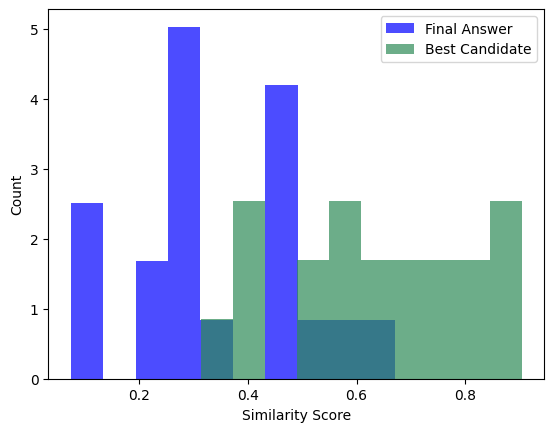

In [34]:
final_ans_scores = []
best_candidate_scores = []
for res in results:
    final_ans_scores.append(res['final answer similarity score'])
    best_candidate_scores.append(res['best similarity score'])

import matplotlib.pyplot as plt
plt.hist(final_ans_scores, alpha=0.7, label='Final Answer', color='blue', density=True)
plt.hist(best_candidate_scores, alpha=0.7, label='Best Candidate', color='seagreen', density=True)
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.legend(['Final Answer', 'Best Candidate'])
plt.show()